In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config Completer.use_jedi = False
from deepdream import dream
from PIL import Image, ImageFilter, ImageChops

In [16]:
def load_image(path):
    image = Image.open(path)
    return image

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()

In [3]:
def dd_helper(image, layer, iterations, lr):        
    
    input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
    mdl.zero_grad()
    for i in range(iterations):
        out = input
        for j in range(layer):
            out = modulelist[j+1](out)
        loss = out.norm()
        loss.backward()
        input.data = input.data + lr * input.grad.data
    
    input = input.data.squeeze()
    input.transpose_(0,1)
    input.transpose_(1,2)
    input = np.clip(deprocess(input).cpu(), 0, 1)
    im = Image.fromarray(np.uint8(input*255))
    return im

In [4]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
            
        image1 = image1.resize(size,Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size,Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
        
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    return img_result

In [5]:
def do_dd(img_normal,modulelist):
    last = len(modulelist[0])
    q1   = int(last/4)
    med  = int(last/2)
    q3   = q1+med
    layer = [[q1],[med],[q3],[last]]
    imag = []
    
    imag.append(img_normal)
    imag.append(deep_dream_vgg(img_normal, q1, 5, 0.3, 2, 20))
    imag.append(deep_dream_vgg(img_normal, med, 5, 0.3, 2, 20))
    imag.append(deep_dream_vgg(img_normal, q3, 5, 0.3, 2, 20))
    imag.append(deep_dream_vgg(img_normal, last, 5, 0.3, 2, 20))
    return imag,layer

In [6]:
def plot_img(img,layer):
    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    for i in range (1,len(img)+1):
        ax = fig.add_subplot(3, 2, i)
        if i == 1:
            title = "Normal Image"
        else:
            title = "Image on Layer = " + str(layer[i-2][0])
        ax.set_title(title,fontweight="bold", size=20)
        ax.imshow(img[i-1],aspect='auto')
    plt.show()

### **AlexNet**

In [7]:
mdl = models.alexnet(pretrained=True)
mdl = mdl.cuda()
modulelist = list(mdl.features.modules())

In [8]:
sky = load_image('sky-dd.jpeg')
img,layer = do_dd(sky,modulelist)

In [9]:
plot_img(img,layer)

### **VGG-16**

In [10]:
mdl = models.vgg16(pretrained=True)
mdl = mdl.cuda()
# print(mdl)
modulelist = list(mdl.features.modules())

In [11]:
sky = load_image('sky-dd.jpeg')
img,layer = do_dd(sky,modulelist)

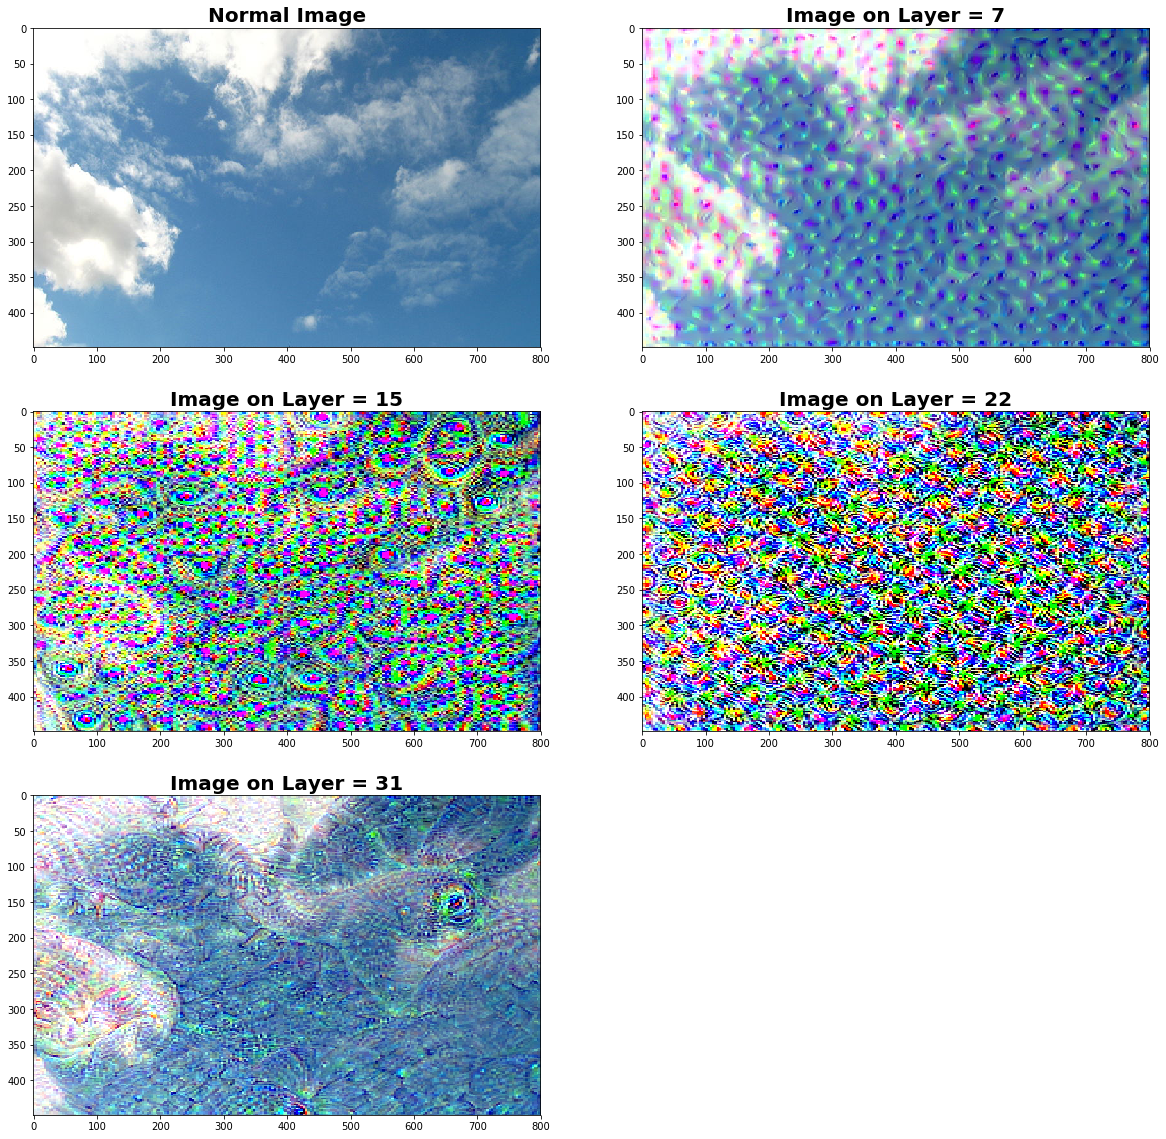

In [12]:
plot_img(img,layer)

### **RESNET**

#### RESNET 50

In [1]:
import torch
from torchvision import transforms
from PIL import Image
from resnet import resnet50
from deepdream import dream

In [5]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
input_img = Image.open('sky-dd.jpeg')
input_tensor = img_transform(input_img).unsqueeze(0)
input_np = input_tensor.numpy()
input_np.shape

(1, 3, 449, 800)

In [5]:
# load model
model = resnet50(pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()
for param in model.parameters():
    param.requires_grad = False

In [6]:
dream(model, input_np)

##### RESNET 18

In [9]:
from resnet import resnet18

In [10]:
input_img = Image.open('sky-dd.jpeg')
input_tensor = img_transform(input_img).unsqueeze(0)
input_np = input_tensor.numpy()
input_np.shape

(1, 3, 449, 800)

In [11]:
# load model
model = resnet50(pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()
for param in model.parameters():
    param.requires_grad = False

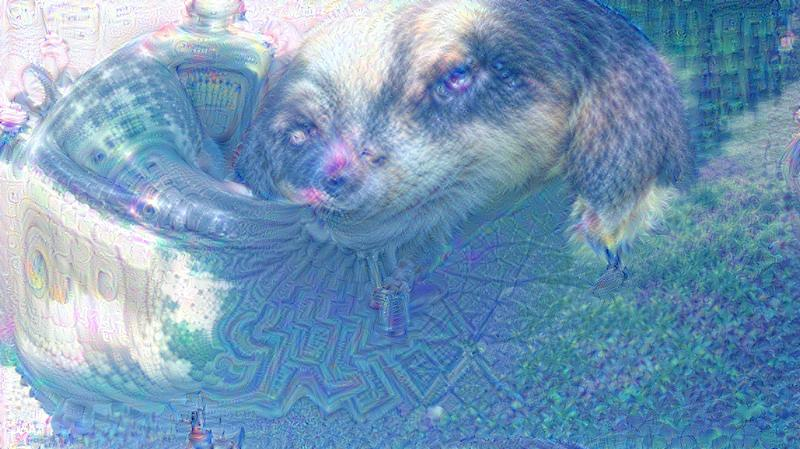

In [12]:
dream(model, input_np)

#### RESNET 34

In [13]:
from resnet import resnet34

In [14]:
input_img = Image.open('sky-dd.jpeg')
input_tensor = img_transform(input_img).unsqueeze(0)
input_np = input_tensor.numpy()
input_np.shape

(1, 3, 449, 800)

In [15]:
# load model
model = resnet50(pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()
for param in model.parameters():
    param.requires_grad = False

In [16]:
dream(model, input_np)

## **REPORT**

#### What is deep dream?

##### Deep dream is an algorithm to visualize a pretrained CNN framework. It can be represent what have been learned by the particular layer of those layers.

#### How Does it works ??

##### I don't fully understand, but as far as aI know from the original work of this project was passing the image to the model. However, just passing the image to the pretrained CNN make the output of the image become different. So, adding algorithm to make sure that the image can be visualize is applied.

<img src="way.png">

##### What you get?

*From the image which I get wheather on alexnet, VGG, or Resnet, all of them give an output that have same meaning. Thats is an original image which have an object(pattern) that  looks like an defined object which usually we see on everyday life. For an example the output of resnet 50. There are a bear, a girrafe neck, foot of a duck, and others. In other hand, we cant see those pattern from original image. However, this pattern can be seen on the output of the others framework, although, the object pattern is not same.*

*Like the original work of deep dream, this phenomena occur because of the pretrained model of the framework itself. The petrained model which use in this program is trained to be an object classification. The ways of object classification algorithm do is  by trying to find that object in the image which we fed to the image. In the case of sky image which I use in this program, we can directly know that there are no object on the image. However, for the object recognition system it will still try to finding every object of the object which ever be trained to them. This is actually done by the system by recreates the image (object most similar / pattern) in a way that it creates an illusion of a tower being there in the image. Then, since the system is actually dreamingthe objects which are not actually present in the image. This system has been named Deep Dream.*

#### **Refference**
- 1. https://hackernoon.com/dl06-deepdream-with-code-5f735052e21f
- 2. https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html
- 3. https://github.com/L1aoXingyu/Deep-Dream
- 4. https://www.kaggle.com/paultimothymooney/pre-trained-pytorch-monkeys-a-deep-dream